# 📘 Projeto de Análise de Dados — Redução de Dimensionalidade
### Integrantes:
- Lucas Gabriel  
- Maria Fernanda  
- Samuel Araújo  

---
Explorar, comparar e analisar diferentes técnicas de redução de dimensionalidade, aplicando-as em um conjunto de dados real. O foco do trabalho é compreender o funcionamento das técnicas, avaliar seus impactos na representação dos dados e discutir as vantagens e limitações de cada método. A atividade é em grupo de até 4 pessoas.

Cada grupo deverá escolher um conjunto de dados real (pode ser de repositórios públicos como UCI Machine Learning Repository, Kaggle ou OpenML) contendo pelo menos 10 variáveis numéricas e mais de 500 amostras.
 proposto.


In [25]:
# 📦 Importações básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✅ Bibliotecas importadas com sucesso!")


✅ Bibliotecas importadas com sucesso!


In [10]:
data = pd.read_csv("estado-de-residencia-do-declarante.csv", delimiter=';', dtype=str)

data = data.apply(lambda x: x.str.replace(',', '.', regex=False))
data = data.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

data_numerico = data.apply(pd.to_numeric, errors='coerce')

colunas_categoricas = ['Estado', 'Ano-Calendário']
colunas_numericas = [c for c in data_numerico.columns if c not in colunas_categoricas]

scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numerico[colunas_numericas].fillna(0))

data_final = pd.concat([data[colunas_categoricas].reset_index(drop=True),
                        pd.DataFrame(data_scaled, columns=colunas_numericas)], axis=1)

print("=== Dataset final com escalonamento aplicado ===")
print(data_final.head())

selector = VarianceThreshold(threshold=0.01)
data_selected = selector.fit_transform(data_scaled)

colunas_mantidas = np.array(colunas_numericas)[selector.get_support()]
colunas_removidas = np.array(colunas_numericas)[~selector.get_support()]

print(f"Features mantidas: {len(colunas_mantidas)}")
print(colunas_mantidas)
print(f"Features removidas: {len(colunas_removidas)}")
print(colunas_removidas)

=== Dataset final com escalonamento aplicado ===
     Estado Ano-Calendário  Quantidade de Declarantes  \
0      Acre           2020                  -0.363484   
1   Alagoas           2020                  -0.242718   
2     Amapá           2020                  -0.361655   
3  Amazonas           2020                  -0.168211   
4     Bahia           2020                   0.458564   

   Rendimentos Tributáveis  Rendimentos sujeitos a Tributação Exclusiva  \
0                -0.306753                                    -0.240388   
1                -0.306543                                    -0.240281   
2                -0.306739                                    -0.240389   
3                -0.306420                                    -0.240225   
4                -0.305398                                    -0.239544   

   Rendimentos Isentos  Dedução Previdenciária Total  \
0            -0.251402                     -0.332365   
1            -0.251257                     -0

In [14]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(data_selected)

pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df = pd.concat([data[colunas_categoricas].reset_index(drop=True), pca_df], axis=1)

print("=== PCA - Primeiras linhas ===")
print(pca_df.head())

print("Variância explicada:")
for i, var in enumerate(pca.explained_variance_ratio_):
    print(f"PC{i+1}: {var*100:.2f}%")
print(f"Total explicado: {sum(pca.explained_variance_ratio_)*100:.2f}%")

=== PCA - Primeiras linhas ===
     Estado Ano-Calendário       PC1       PC2
0      Acre           2020 -0.421001 -1.430274
1   Alagoas           2020  0.351849 -1.183102
2     Amapá           2020 -0.302209 -1.392389
3  Amazonas           2020  0.595329 -1.105891
4     Bahia           2020  4.319583  0.086089
Variância explicada:
PC1: 51.87%
PC2: 40.14%
Total explicado: 92.01%


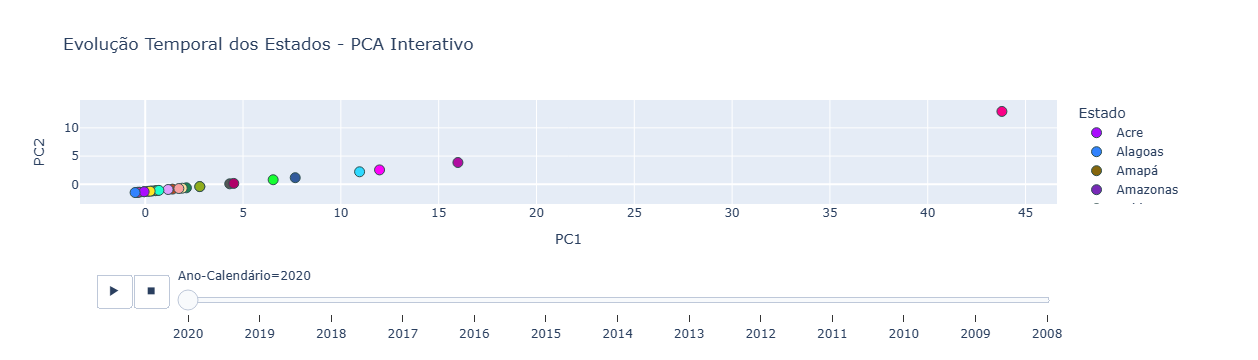

In [15]:
fig = px.scatter(
    pca_df,
    x="PC1", y="PC2",
    color="Estado",
    animation_frame="Ano-Calendário",
    title="Evolução Temporal dos Estados - PCA Interativo",
    color_discrete_sequence=px.colors.qualitative.Alphabet
)
fig.update_traces(marker=dict(size=10, line=dict(width=1, color='DarkSlateGrey')))
fig.show()

O Autoencoder é uma rede neural artificial usada principalmente para redução de dimensionalidade e detecção de padrões ocultos nos dados. Ele funciona de forma não supervisionada, ou seja, aprende sozinho a reconstruir a entrada na saída. A rede é composta por duas partes: o encoder (codificador), que comprime os dados em uma representação de menor dimensão, e o decoder (decodificador), que tenta reconstruir os dados originais a partir dessa forma comprimida. O Autoencoder foi utilizado como técnica de redução de dimensionalidade e extração de características. O modelo foi construído com três camadas de codificação e três de decodificação. O codificador comprime as variáveis originais em um espaço de 8 dimensões, muito menor do que o número inicial de atributos. Durante o treino, o Autoencoder aprende a reconstruir os dados de entrada a partir dessa versão comprimida, ajustando seus pesos para minimizar o erro médio quadrático (loss = MSE).

Antes de aplicar o modelo, realizamos um pré-processamento completo dos dados. Primeiro, carregamos o conjunto de informações e identificamos a variável alvo, “Estado”, que representa o estado de residência do declarante. Em seguida, removemos essa coluna das variáveis explicativas e aplicamos o one-hot encoding para converter as variáveis categóricas em valores numéricos binários, permitindo que o modelo as interprete corretamente. Após essa conversão, os dados foram padronizados com o StandardScaler, de modo que todas as variáveis tivessem média zero e desvio padrão igual a um. Isso evita que atributos com escalas diferentes influenciem desproporcionalmente o treinamento. Por fim, o conjunto foi dividido em dados de treino (80%) e teste (20%), o que garante uma avaliação imparcial do desempenho do modelo. Durante o treinamento, o Autoencoder aprende quais características mais importantes dos dados são necessárias para reconstruí-los corretamente. Essa representação reduzida é muito útil para visualizações, compressão de dados e detecção de anomalias, pois retém apenas as informações essenciais. Diferente de métodos lineares como o PCA, o Autoencoder pode capturar relações não lineares complexas, tornando-se uma ferramenta poderosa em problemas com muitos atributos correlacionados. Após o treinamento, utilizamos apenas a parte codificadora do modelo para gerar as representações comprimidas, que são chamadas de “features latentes”. Essas novas variáveis condensam as informações mais importantes do conjunto original, permitindo explorar padrões e semelhanças entre os estados de forma mais clara. Essa redução também facilita a visualização e interpretação dos dados em 2D e 3D.

In [16]:
# Carregar o dataset
df = pd.read_csv("estado-de-residencia-do-declarante.csv", sep=';')

#Mostra as colunass que serão analisadas do dataset
print("Dimensões do dataset:", df.shape)
list(df.columns)

Dimensões do dataset: (610, 43)


['Ano-Calendário',
 'Estado',
 'Quantidade de Declarantes',
 'Rendimentos Tributáveis',
 'Rendimentos sujeitos a Tributação Exclusiva',
 'Rendimentos Isentos',
 'Dedução Previdenciária Total',
 'Deduções Previdência Oficial',
 'Deduções Previdenciárias RRA',
 'Deduções Previdência Privada e FAPI',
 'Deduções com Dependentes',
 'Deduções com Instrução',
 'Deduções com despesas Médicas',
 'Dedução de Livro Caixa',
 'Deduções  com Pensão Alimentícia Total',
 'Deduções com Pensão Alimentícia Judicial',
 'Deduções com Pensão Alimentícia Escritural',
 'Deduções com Pensão Alimentícia RRA',
 'Desconto Padrão',
 'Base de Cálculo (RTL)',
 'Imposto Devido',
 'Dedução de Incentivo',
 'Imposto Devido 1',
 'Imposto Devido RRA',
 'Imposto Devido Total',
 'Imposto Pago',
 'Imposto a Pagar',
 'Imposto a Restituir',
 'Dívidas   e Ônus',
 'Doações e Heranças Recebidas',
 'Bens e Direitos',
 'Previdência Complementar (VGBL)',
 'Valores Pagos com Previdência Complementar (PGBL)',
 'Valores Pagos com Previ

In [18]:
# Substitui valores infinitos (inf e -inf) por NaN
df = df.replace([np.inf, -np.inf], np.nan)

# Preenche valores faltantes (NaN) com a média de cada coluna numérica
df = df.fillna(df.mean(numeric_only=True))


In [19]:
y = df['Estado']

X = df.drop(columns=['Estado'])

# Converter variáveis categóricas em numéricas
X_encoded = pd.get_dummies(X, drop_first=True)

In [20]:
# Normaliza os dados entre 0 e 1 para facilitar o aprendizado do modelo
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_encoded)

# Divide os dados em conjuntos de treino (80%) e teste (20%)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# Exibe confirmação e formatos das divisões
print("✅ Dados preparados!")
print("Formato treino:", X_train.shape)
print("Formato teste:", X_test.shape)


✅ Dados preparados!
Formato treino: (488, 13479)
Formato teste: (122, 13479)


In [23]:
# Define o número de entradas (colunas) e de dimensões reduzidas
input_dim = X_train.shape[1]
encoding_dim = 8  # tamanho da representação comprimida

# Camada de entrada
input_layer = layers.Input(shape=(input_dim,))

# Parte de codificação (compressão dos dados)
encoded = layers.Dense(64, activation='relu')(input_layer)
encoded = layers.Dense(32, activation='relu')(encoded)
encoded = layers.Dense(encoding_dim, activation='relu')(encoded)

# Parte de decodificação (reconstrução dos dados originais)
decoded = layers.Dense(32, activation='relu')(encoded)
decoded = layers.Dense(64, activation='relu')(decoded)
decoded = layers.Dense(input_dim, activation='linear')(decoded)

# Criação e compilação do modelo Autoencoder
autoencoder = models.Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Mostra o resumo da arquitetura da rede
autoencoder.summary()


2025-11-09 23:09:27.100970: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 13479)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       862,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 13479)          │       876,135 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,743,599 (6.65 MB)

 Trainable params: 1,743,599 (6.65 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = autoencoder.fit(
    X_train, X_train,                 # Entrada e saída são iguais (autoencoder reconstrói os dados)
    epochs=50,                        # Treinar por 50 épocas
    batch_size=64,                    # Processa 64 amostras por vez
    shuffle=True,                     # Embaralha os dados a cada época
    validation_data=(X_test, X_test), # Usa dados de teste para avaliar o erro de reconstrução
    verbose=1                         # Mostra o progresso do treino
)


NameError: name 'autoencoder' is not defined

In [51]:
# Cria o modelo do codificador (pega só a parte de compressão do autoencoder)
encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.layers[3].output)

# Gera as representações comprimidas dos dados de treino e teste
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

# Mostra as formas antes e depois da redução
print("Forma original:", X_train.shape)
print("Forma reduzida:", X_train_encoded.shape)

# Cria um DataFrame com as novas features comprimidas
encoded_df = pd.DataFrame(X_train_encoded, columns=[f'feat_{i+1}' for i in range(X_train_encoded.shape[1])])

# Exibe estatísticas descritivas das novas dimensões
print(encoded_df.describe().T)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Forma original: (488, 13479)
Forma reduzida: (488, 8)
        count      mean       std  min       25%       50%       75%       max
feat_1  488.0  0.024397  0.091758  0.0  0.000000  0.000000  0.005308  1.183817
feat_2  488.0  0.339138  0.361152  0.0  0.108870  0.284857  0.376867  2.075109
feat_3  488.0  0.154057  0.243770  0.0  0.026287  0.094862  0.162980  2.226454
feat_4  488.0  0.130288  0.257778  0.0  0.000000  0.053495  0.130339  2.252955
feat_5  488.0  0.184736  0.305508  0.0  0.024859  0.090980  0.187805  2.584283
feat_6  488.0  0.137397  0.223747  0.0  0.002847  0.074162  0.165768  1.622511
feat_7  488.0  0.007070  0.047415  0.0  0.000000  0.000000  0.000000  0.705258
feat_8  488.0  0.274094  0.322704  0.0  0.084711  0.191200  0.302693  2.355733


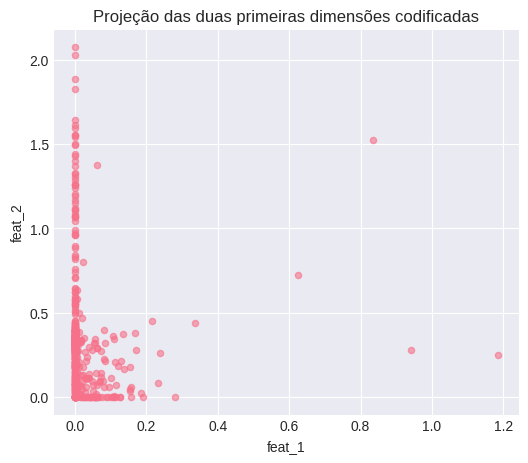

In [53]:
# Cria um gráfico de dispersão (scatter plot) com as duas primeiras dimensões reduzidas
plt.figure(figsize=(6, 5))
plt.scatter(encoded_df['feat_1'], encoded_df['feat_2'], s=20, alpha=0.6)

# Define título e rótulos dos eixos
plt.title("Projeção das duas primeiras dimensões codificadas")
plt.xlabel("feat_1")
plt.ylabel("feat_2")

# Exibe o gráfico
plt.show()


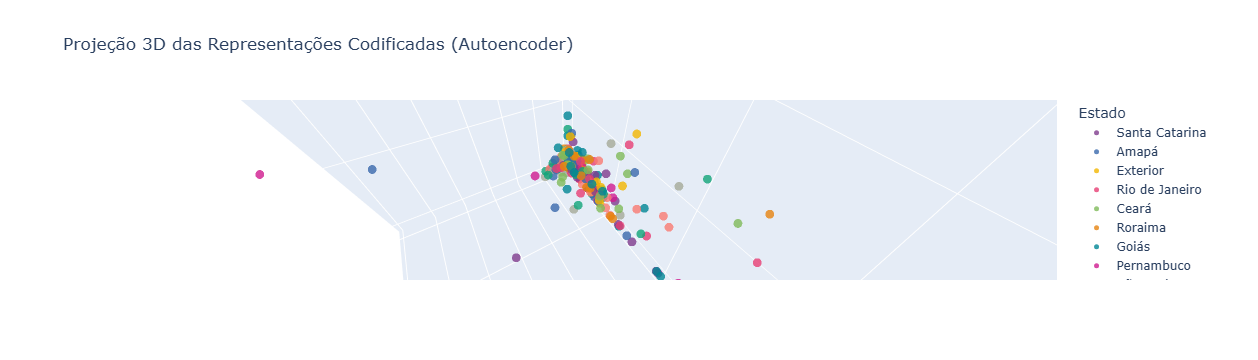

In [54]:
from sklearn.model_selection import train_test_split
import plotly.express as px

# Separa variável-alvo e preditoras
y = df['Estado']
X = df.drop(columns=['Estado'])

# Converte variáveis categóricas em numéricas (one-hot encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Divide em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)

# Cria DataFrame com as 3 primeiras dimensões codificadas (saída do encoder)
df_encoded = pd.DataFrame(X_train_encoded[:, :3], columns=['Dim1', 'Dim2', 'Dim3'])

# Adiciona a coluna da variável-alvo (Estado)
df_encoded['Estado'] = y_train.values

# Gera gráfico 3D interativo com Plotly
fig = px.scatter_3d(
    df_encoded, 
    x='Dim1', 
    y='Dim2', 
    z='Dim3',
    color='Estado',
    title='Projeção 3D das Representações Codificadas (Autoencoder)',
    opacity=0.8,
    color_discrete_sequence=px.colors.qualitative.Bold
)

# Ajusta tamanho dos pontos e exibe o gráfico
fig.update_traces(marker=dict(size=5))
fig.show()


O t-SNE (t-Distributed Stochastic Neighbor Embedding) é uma técnica de redução de dimensionalidade não-linear utilizada para transformar dados de alta dimensão em um espaço de duas ou três dimensões, permitindo uma visualização intuitiva dos padrões e agrupamentos no dataset. Diferente de métodos lineares como o PCA, o t-SNE preserva principalmente a estrutura local dos dados, ou seja, pontos que são próximos no espaço original continuam próximos após a redução dimensional. 

Nesse sentido, o t-SNE foi aplicado aos dados numéricos escalonados (data_scaled) para reduzir suas dimensões para duas, gerando um DataFrame com as colunas resultantes Dim1 e Dim2, associadas à categoria “Estado” do declarante. Antes da visualização, os valores da coluna foram padronizados e limpos, removendo valores nulos ou vazios, garantindo que apenas dados válidos fossem exibidos. Por fim, foi gerado um gráfico de dispersão 2D com o Seaborn, no qual cada ponto representa um registro do dataset, e a cor indica o estado correspondente. Essa visualização permite identificar agrupamentos e os padrões de forma clara e intuitiva, facilitando a análise dos dado.jacente.


In [35]:
#Utilizando o t-SNE para reduzir para 2 dimesões
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    max_iter=1000,
    random_state=42,
    verbose=1
)

# Executando os dados numéricos escalonados
X_tsne = tsne.fit_transform(data_scaled)

# Cria DataFrame
tsne_df = pd.DataFrame(X_tsne, columns=['Dim1', 'Dim2'])
tsne_df['Estado'] = data_final['Estado'].values  

tsne_df['Estado'] = tsne_df['Estado'].str.strip().str.lower()

# removendo os valores nulos ou vazios
tsne_df = tsne_df.dropna(subset=['Estado'])           
tsne_df = tsne_df[tsne_df['Estado'] != '']            # remove as strings vazias

print(tsne_df['Estado'].unique())

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 610 samples in 0.000s...
[t-SNE] Computed neighbors for 610 samples in 0.009s...
[t-SNE] Computed conditional probabilities for sample 610 / 610
[t-SNE] Mean sigma: 0.044276
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.846478
[t-SNE] KL divergence after 1000 iterations: 0.163277
['acre' 'alagoas' 'amapá' 'amazonas' 'bahia' 'ceará' 'distrito federal'
 'espírito santo' 'goiás' 'maranhão' 'mato grosso' 'mato grosso do sul'
 'minas gerais' 'paraná' 'paraíba' 'pará' 'pernambuco' 'piauí'
 'rio grande do norte' 'rio grande do sul' 'rio de janeiro' 'rondônia'
 'roraima' 'santa catarina' 'sergipe' 'são paulo' 'tocantins'
 'não identificado' 'não se aplica' 'exterior' 'não informado']


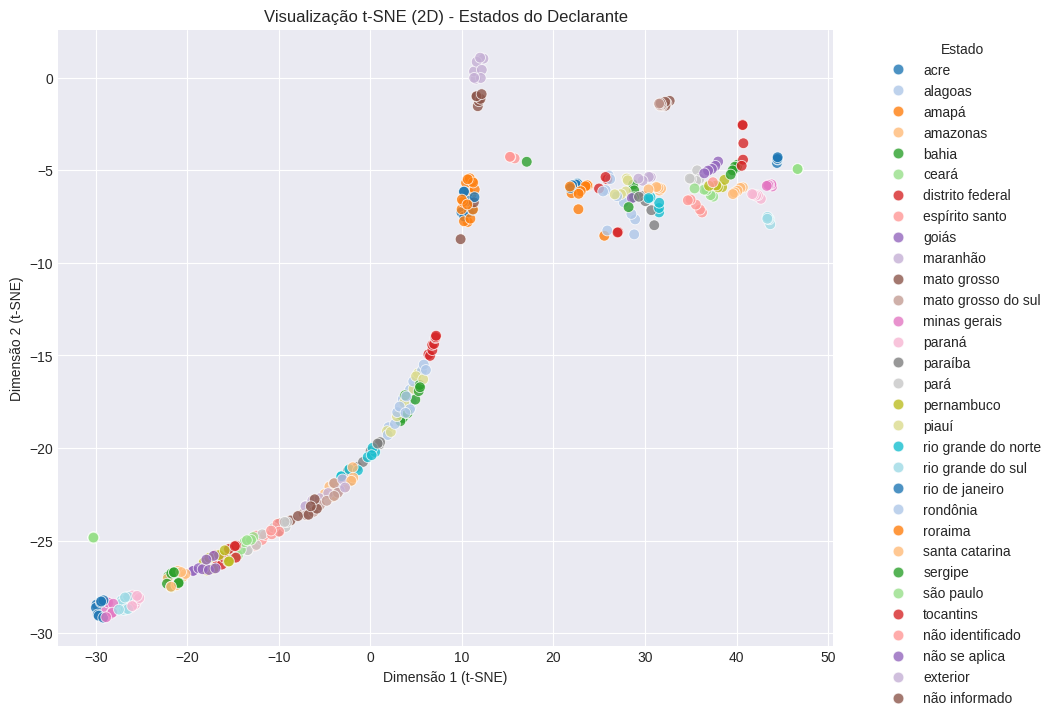

In [34]:
# Visualização estática 
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=tsne_df,
    x='Dim1', y='Dim2',
    hue='Estado',
    palette='tab20',
    s=60,
    alpha=0.8
)
plt.title("Visualização t-SNE (2D) - Estados do Declarante")
plt.xlabel("Dimensão 1")
plt.ylabel("Dimensão 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Estado')
plt.show()
